# Explore here

In [118]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings

# Suprimir sólo las advertencias de la librería sklearn
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')


In [119]:
datos_ventas = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

datos_ventas.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [120]:
datos_ventas["date"] = pd.to_datetime(datos_ventas.date)
datos_ventas = datos_ventas.set_index("date")
ts_total = datos_ventas["sales"]
ts_total.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

Train dates : 2022-09-03 17:10:08.079328 --- 2023-06-01 17:10:08.079328  (n=272)
Test dates  : 2023-06-01 17:10:08.079328 --- 2023-09-03 17:10:08.079328  (n=95)


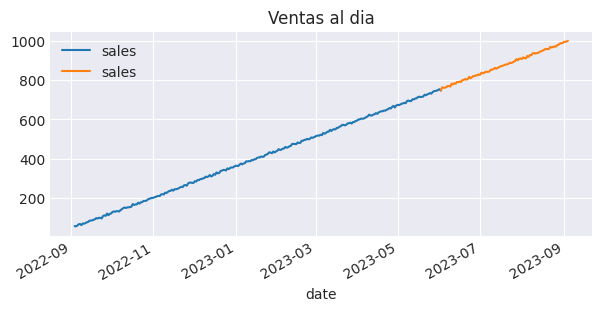

In [121]:
end_train = '2023-06-01 17:10:08'
print(
    f"Train dates : {datos_ventas.index.min()} --- {datos_ventas.loc[:end_train].index.max()}  "
    f"(n={len(datos_ventas.loc[:end_train])})"
)
print(
    f"Test dates  : {datos_ventas.loc[end_train:].index.min()} --- {datos_ventas.loc[:].index.max()}  "
    f"(n={len(datos_ventas.loc[end_train:])})"
)
data_train = datos_ventas.loc[:end_train]
data_test  = datos_ventas.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Ventas al dia')
ax.legend();

Test stationarity for original series
-------------------------------------
ADF Statistic: 0.545414193706378, p-value: 0.9861899815311064
KPSS Statistic: 3.1523824466446215, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -9.430263118334729, p-value: 5.212954111417404e-16
KPSS Statistic: 0.07918595776640563, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -12.25445097626378, p-value: 9.379248591728374e-23
KPSS Statistic: 0.04245705341117472, p-value: 0.1


/tmp/ipykernel_7369/3028570580.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(datos_ventas)
/tmp/ipykernel_7369/3028570580.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(datos_ventas.diff().dropna())
/tmp/ipykernel_7369/3028570580.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(datos_ventas.diff().diff().dropna())


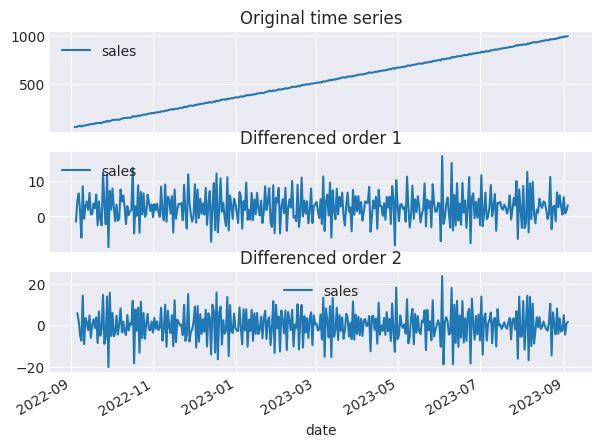

In [122]:
from statsmodels.tsa.stattools import kpss

data_diff_1 = datos_ventas.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(datos_ventas)
kpss_result = kpss(datos_ventas)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(datos_ventas.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(datos_ventas.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos_ventas.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

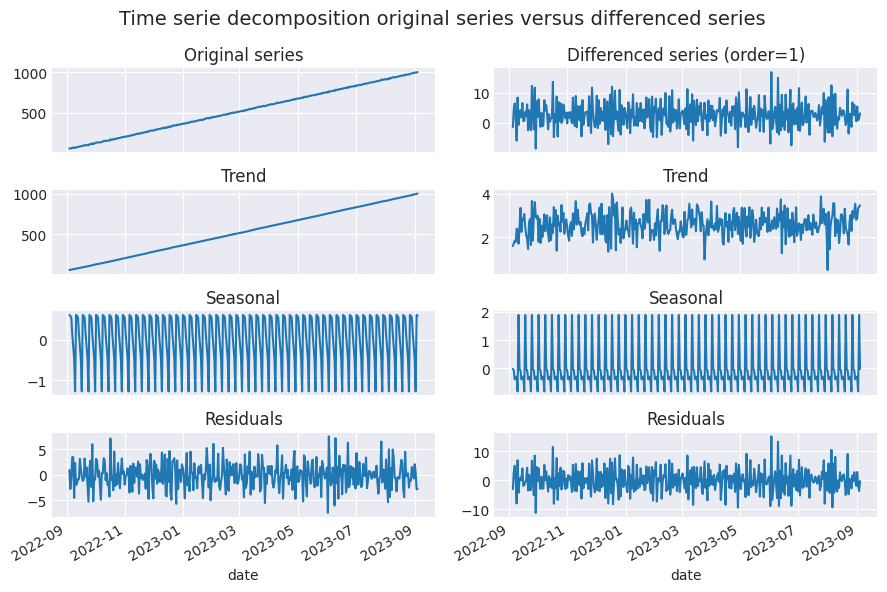

In [123]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(datos_ventas, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

In [124]:
# Diferenciar la serie para remover tendencia
datos_ventas['diff_sales'] = datos_ventas['sales'].diff().dropna()

ts_flights_dif = datos_ventas["sales"]
ts_flights_dif.dropna(inplace = True)

ts_flights_dif

date
2022-09-03 17:10:08.079328      55.292157
2022-09-04 17:10:08.079328      53.803211
2022-09-05 17:10:08.079328      58.141693
2022-09-06 17:10:08.079328      64.530899
2022-09-07 17:10:08.079328      66.013633
                                 ...     
2023-08-30 17:10:08.079328     989.600354
2023-08-31 17:10:08.079328     994.987326
2023-09-01 17:10:08.079328     995.814415
2023-09-02 17:10:08.079328     997.350214
2023-09-03 17:10:08.079328    1000.482785
Name: sales, Length: 366, dtype: float64

Tanto en mi valroes diferenciados como 

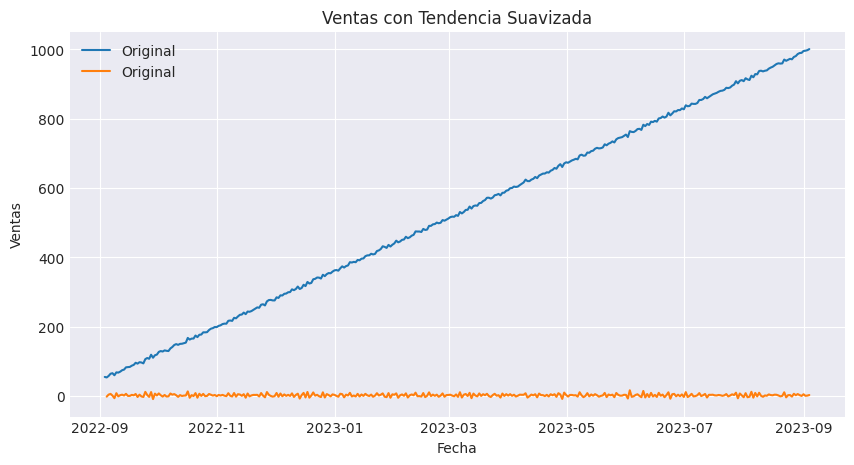

In [125]:
plt.figure(figsize=(10,5))
plt.plot(datos_ventas, label="Original")
plt.legend()
plt.title("Ventas con Tendencia Suavizada")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid(True)
plt.show()


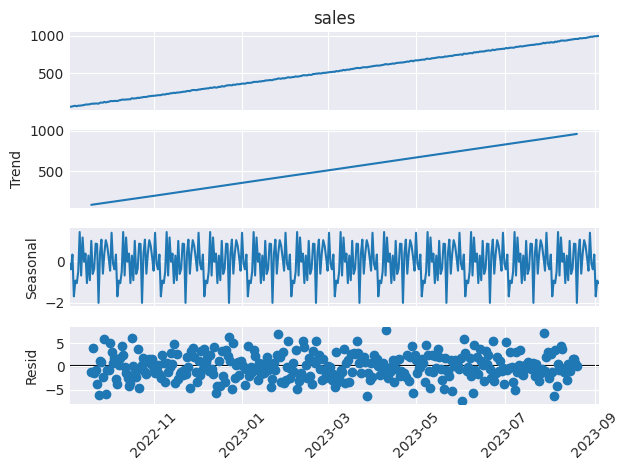

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(datos_ventas["sales"], period=30)
decomp.plot()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [127]:
train_size = int(len(datos_ventas) * 0.8)
train, test = datos_ventas["sales"][:train_size], datos_ventas["sales"][train_size:]

In [128]:
from skforecast.sarimax import Sarimax

warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelSar = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelSar.fit(y=data_train)
modelSar.summary()
warnings.filterwarnings("default")
# Prediction
# ==============================================================================
predictions_skforecast = modelSar.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']
display(predictions_skforecast.head(4))

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,skforecast
2023-06-02 17:10:08.079328,755.056875
2023-06-03 17:10:08.079328,759.082663
2023-06-04 17:10:08.079328,761.422040
2023-06-05 17:10:08.079328,764.338411


In [129]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelSAX = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = modelSAX.fit(disp=0)
warnings.filterwarnings("default")
model_res.summary()

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  272
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -665.837
Date:                            Wed, 07 May 2025   AIC                           1341.673
Time:                                    12:01:14   BIC                           1359.457
Sample:                                09-03-2022   HQIC                          1348.824
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0179      0.066     -0.269      0.788      -0.148       0.112
ma.L1         -0.9262      0.030    -31.382      0.000      -0.984      -0.868
ar.S.L12      -0.0447      0.075     -0.594      0.553      -0.192       0.103
ma.S.L12      -0.9992      6.285     -0.159      0.874     -13.317      11.319
sigma2         8.5389     53.341      0.160      0.873     -96.008     113.086
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.89   Prob(JB):                         0.99
Heteroskedasticity (H):               0.94   Skew:                             0.01
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
modelAr = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelAr.fit(y=data_train)
modelAr.summary()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  272
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -665.825
Date:                            Wed, 07 May 2025   AIC                           1343.649
Time:                                    12:01:16   BIC                           1364.990
Sample:                                09-03-2022   HQIC                          1352.230
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.145      0.885      -0.004       0.005
ar.L1         -0.0183      0.068     -0.269      0.788      -0.151       0.115
ma.L1         -0.9259      0.030    -31.320      0.000      -0.984      -0.868
ar.S.L12      -0.0451      0.076     -0.592      0.554      -0.194       0.104
ma.S.L12      -0.9974      1.937     -0.515      0.607      -4.794       2.799
sigma2         8.5551     16.243      0.527      0.598     -23.280      40.390
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.90   Prob(JB):                         0.99
Heteroskedasticity (H):               0.94   Skew:                             0.01
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
predictions_pdmarima = modelAr.predict(len(data_test))
predictions_pdmarima.name = 'predictions_pdmarima'
display(predictions_pdmarima.head(4))

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-06-02 17:10:08.079328    755.110382
2023-06-03 17:10:08.079328    759.135150
2023-06-04 17:10:08.079328    761.479214
2023-06-05 17:10:08.079328    764.399091
Freq: D, Name: predictions_pdmarima, dtype: float64

In [132]:
predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
display(predictions_statsmodels.head(4))

2023-06-02 17:10:08.079328    755.056875
2023-06-03 17:10:08.079328    759.082663
2023-06-04 17:10:08.079328    761.422040
2023-06-05 17:10:08.079328    764.338411
Freq: D, Name: predictions_statsmodels, dtype: float64

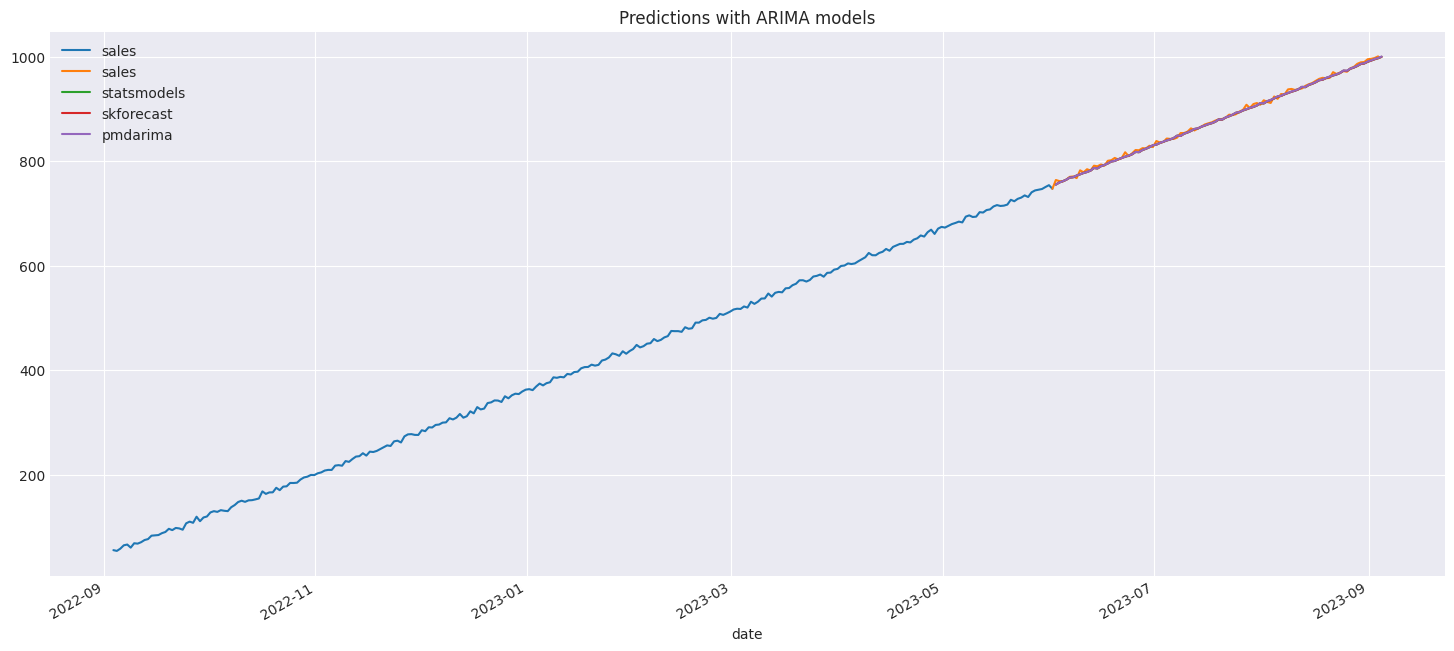

In [133]:
fig, ax = plt.subplots(figsize=(18, 8))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_statsmodels.plot(ax=ax, label='statsmodels')
predictions_skforecast.plot(ax=ax, label='skforecast')
predictions_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend();

In [134]:
from pmdarima import auto_arima

# Ajustar el modelo ARIMA utilizando auto_arima
model = auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)

# Imprimir los mejores parámetros
print(model.summary())

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1483.238, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1675.428, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1579.885, Time=0.15 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1477.110, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1763.761, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1475.165, Time=0.07 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1477.106, Time=0.48 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1478.877, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1475.512, Time=0.12 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1475.495, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1578.564, Time=0.04 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1479.028, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1762.924, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 3.080 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -734.582
Date:                Wed, 07 May 2025   AIC                           1475.165
Time:                        12:01:19   BIC                           1486.185
Sample:                    09-03-2022   HQIC                          1479.579
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [135]:
datos_ventas = datos_ventas.asfreq('D', fill_value=np.nan)  # O 'M' si los datos son mensuales.

In [136]:
forecaster = ForecasterSarimax(
                regressor = Sarimax(
                    order          = (0, 1, 1),
                    seasonal_order = (1, 1, 1, 12),
                    maxiter        = 500
                )
)
forecaster.fit(y=datos_ventas['sales'].loc[:end_train])

In [137]:
last_window = datos_ventas.loc[end_train:].copy()
last_window = last_window.asfreq('D', fill_value=np.nan)  # Ajustar frecuencia

In [138]:
forecaster.fit(y=datos_ventas['sales'].loc[:end_train])

# Hacer las predicciones con el índice con frecuencia establecida
predictions = forecaster.predict(
    steps=12
)

# Mostrar las primeras 3 predicciones
print(predictions.head(3))

2023-06-02 17:10:08.079328    754.906067
2023-06-03 17:10:08.079328    759.089363
2023-06-04 17:10:08.079328    761.425844
Freq: D, Name: pred, dtype: float64


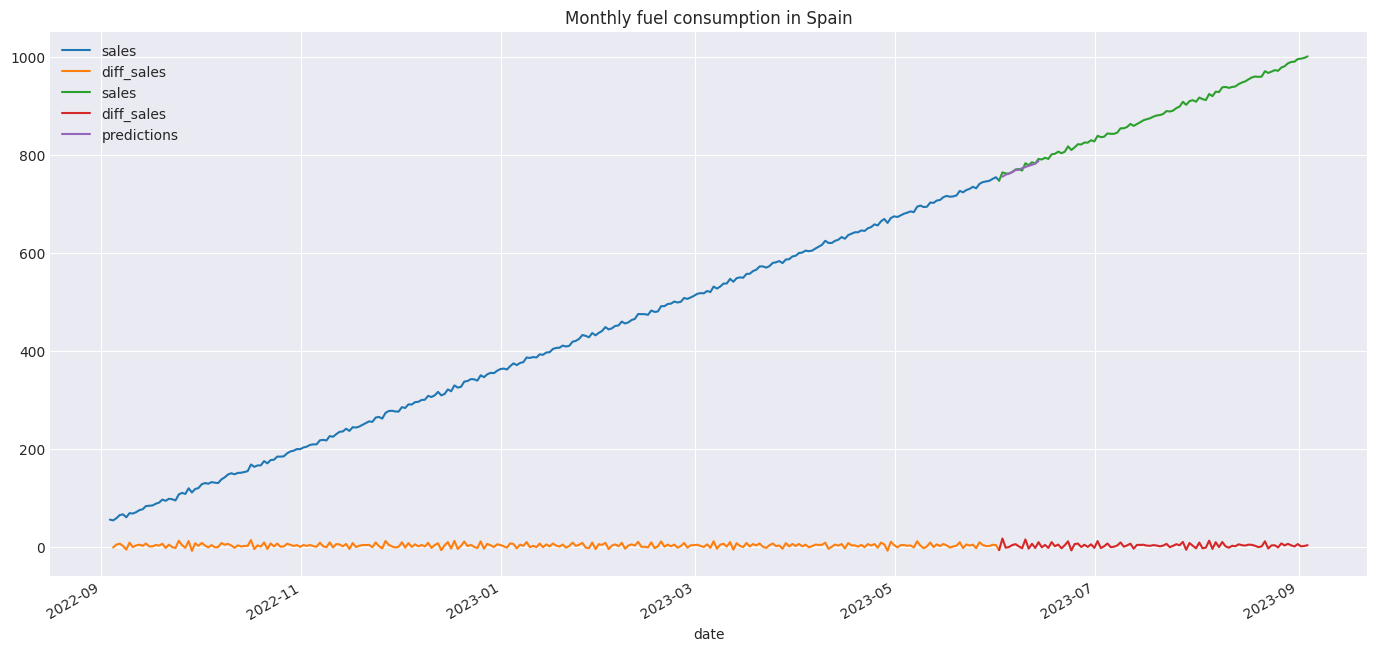

In [139]:
fig, ax = plt.subplots(figsize=(17, 8))
datos_ventas.loc[:end_train].plot(ax=ax, label='train')
datos_ventas.loc[end_train:].plot(ax=ax, label='last window')
predictions.plot(ax=ax, label='predictions')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

In [140]:
from pmdarima.arima import ARIMA

# Definir el mejor modelo manualmente (sin búsqueda automática)
model2 = ARIMA(order=(0, 1, 1), seasonal_order=(0, 0, 0, 12), with_intercept=True)

# Ajustar el modelo a los datos de entrenamiento
model2.fit(train)

# Ver resumen
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -734.582
Date:                Wed, 07 May 2025   AIC                           1475.165
Time:                        12:01:21   BIC                           1486.185
Sample:                    09-03-2022   HQIC                          1479.579
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5984      0.011    243.641      0.000       2.577       2.619
ma.L1         -0.9439      0.021    -44.117      0.000      -0.986      -0.902
sigma2         9.0537      0.817     11.084      0.0

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


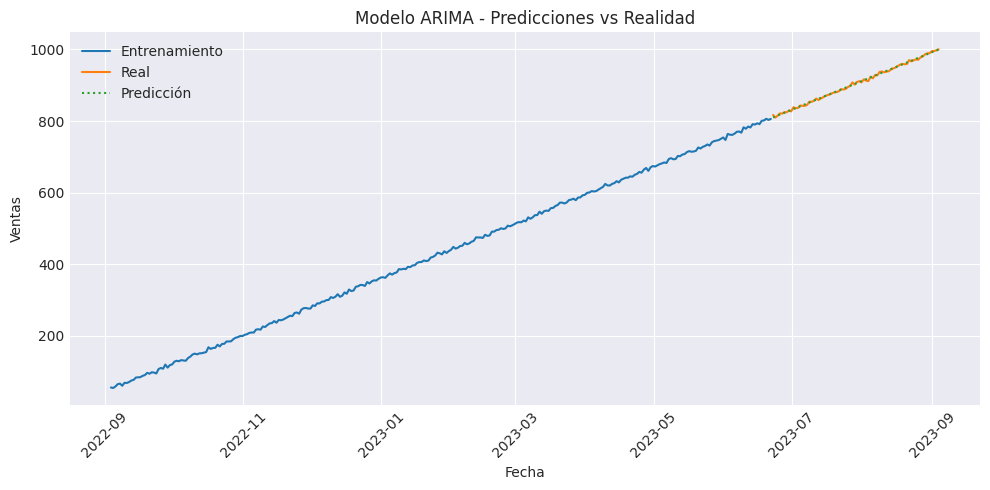

In [141]:
# Predecir los siguientes valores (igual al largo del conjunto de prueba)
forecast2 = model.predict(n_periods=len(test))

plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Entrenamiento")
plt.plot(test.index, test, label="Real")
plt.plot(test.index, forecast2, label="Predicción", linestyle=":")
plt.legend()
plt.title("Modelo ARIMA - Predicciones vs Realidad")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Mi prediccion no tiene ruido, pero coincide bastante con lo que predice mi modelo. 

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


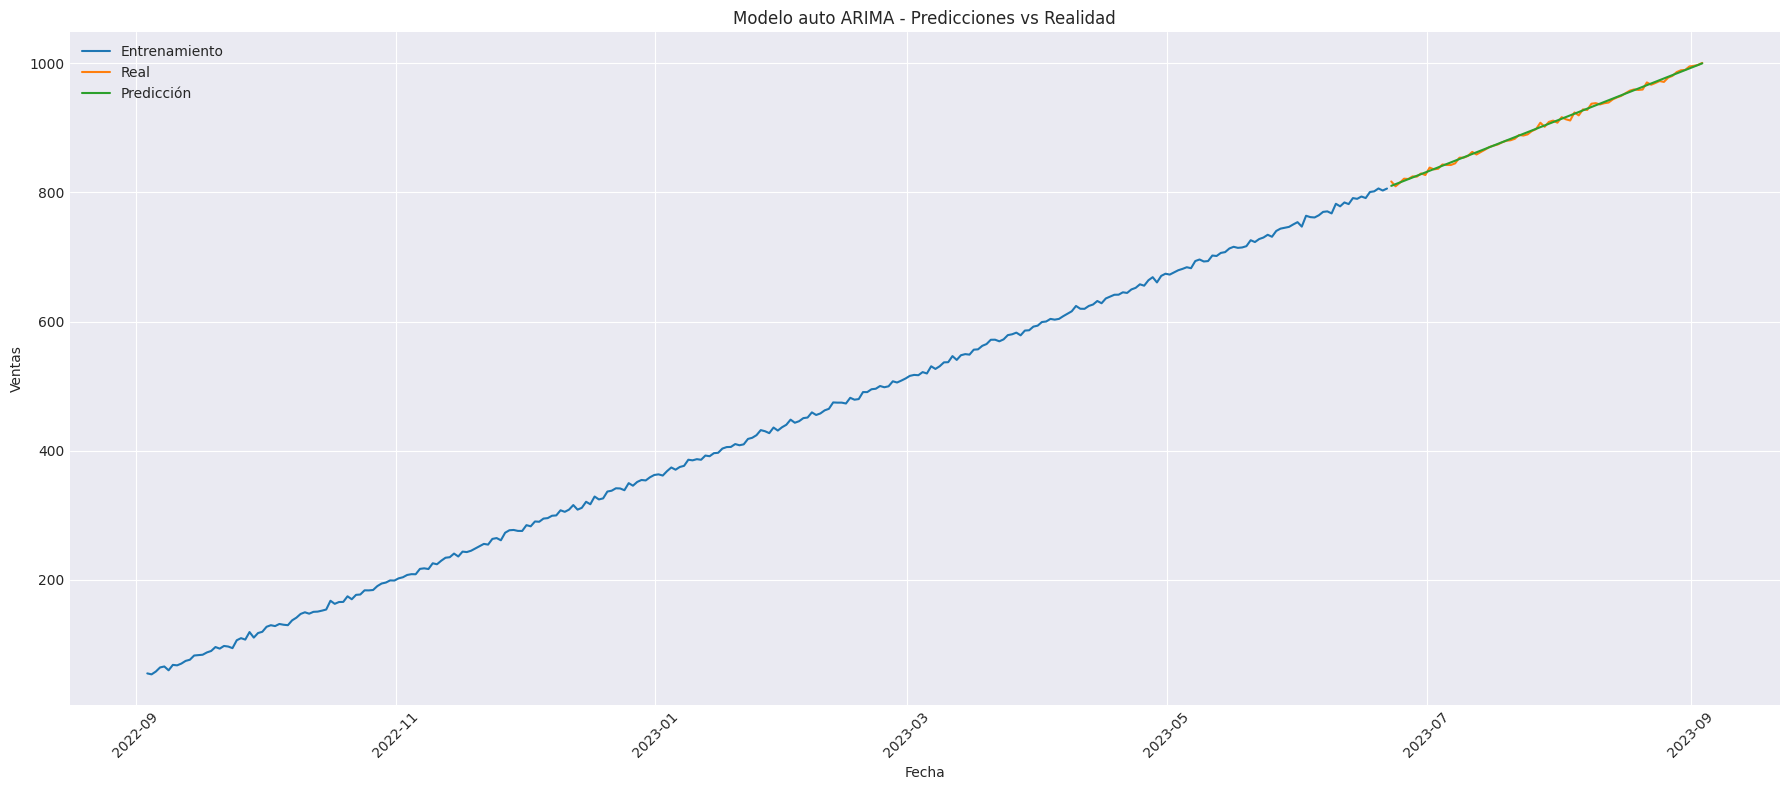

In [142]:
forecast = model.predict(n_periods=len(test))

# Graficar resultados
plt.figure(figsize=(18, 8))
plt.plot(train.index, train, label="Entrenamiento")
plt.plot(test.index, test, label="Real")
plt.plot(test.index, forecast, label="Predicción", linestyle="-")
plt.legend()
plt.title("Modelo auto ARIMA - Predicciones vs Realidad")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [143]:
import joblib

# Guardar el modelo entrenado
joblib.dump(model, '../models/modelo_pruebas2.pkl')

['../models/modelo_pruebas2.pkl']